# Прогнозирование оттока клиентов Банка

## 1. Подготовка данных

### 1.1 Загрузка библиотек

In [1]:
#все импорты и настройки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE

from catboost import CatBoostClassifier

pd.options.display.max_columns = 100
pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

### 1.2 Загрузка и изучение данных

In [2]:
#загрузка датасета в переменную data
try:
    data = pd.read_csv('/datasets/Churn.csv')
except:
    data = pd.read_csv('C:/Users/Mi/Desktop/churn/Churn.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
#информация о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


В датасете 10000 строк и 14 признаков, в колонке Tenure замечены пропуски

In [4]:
data.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


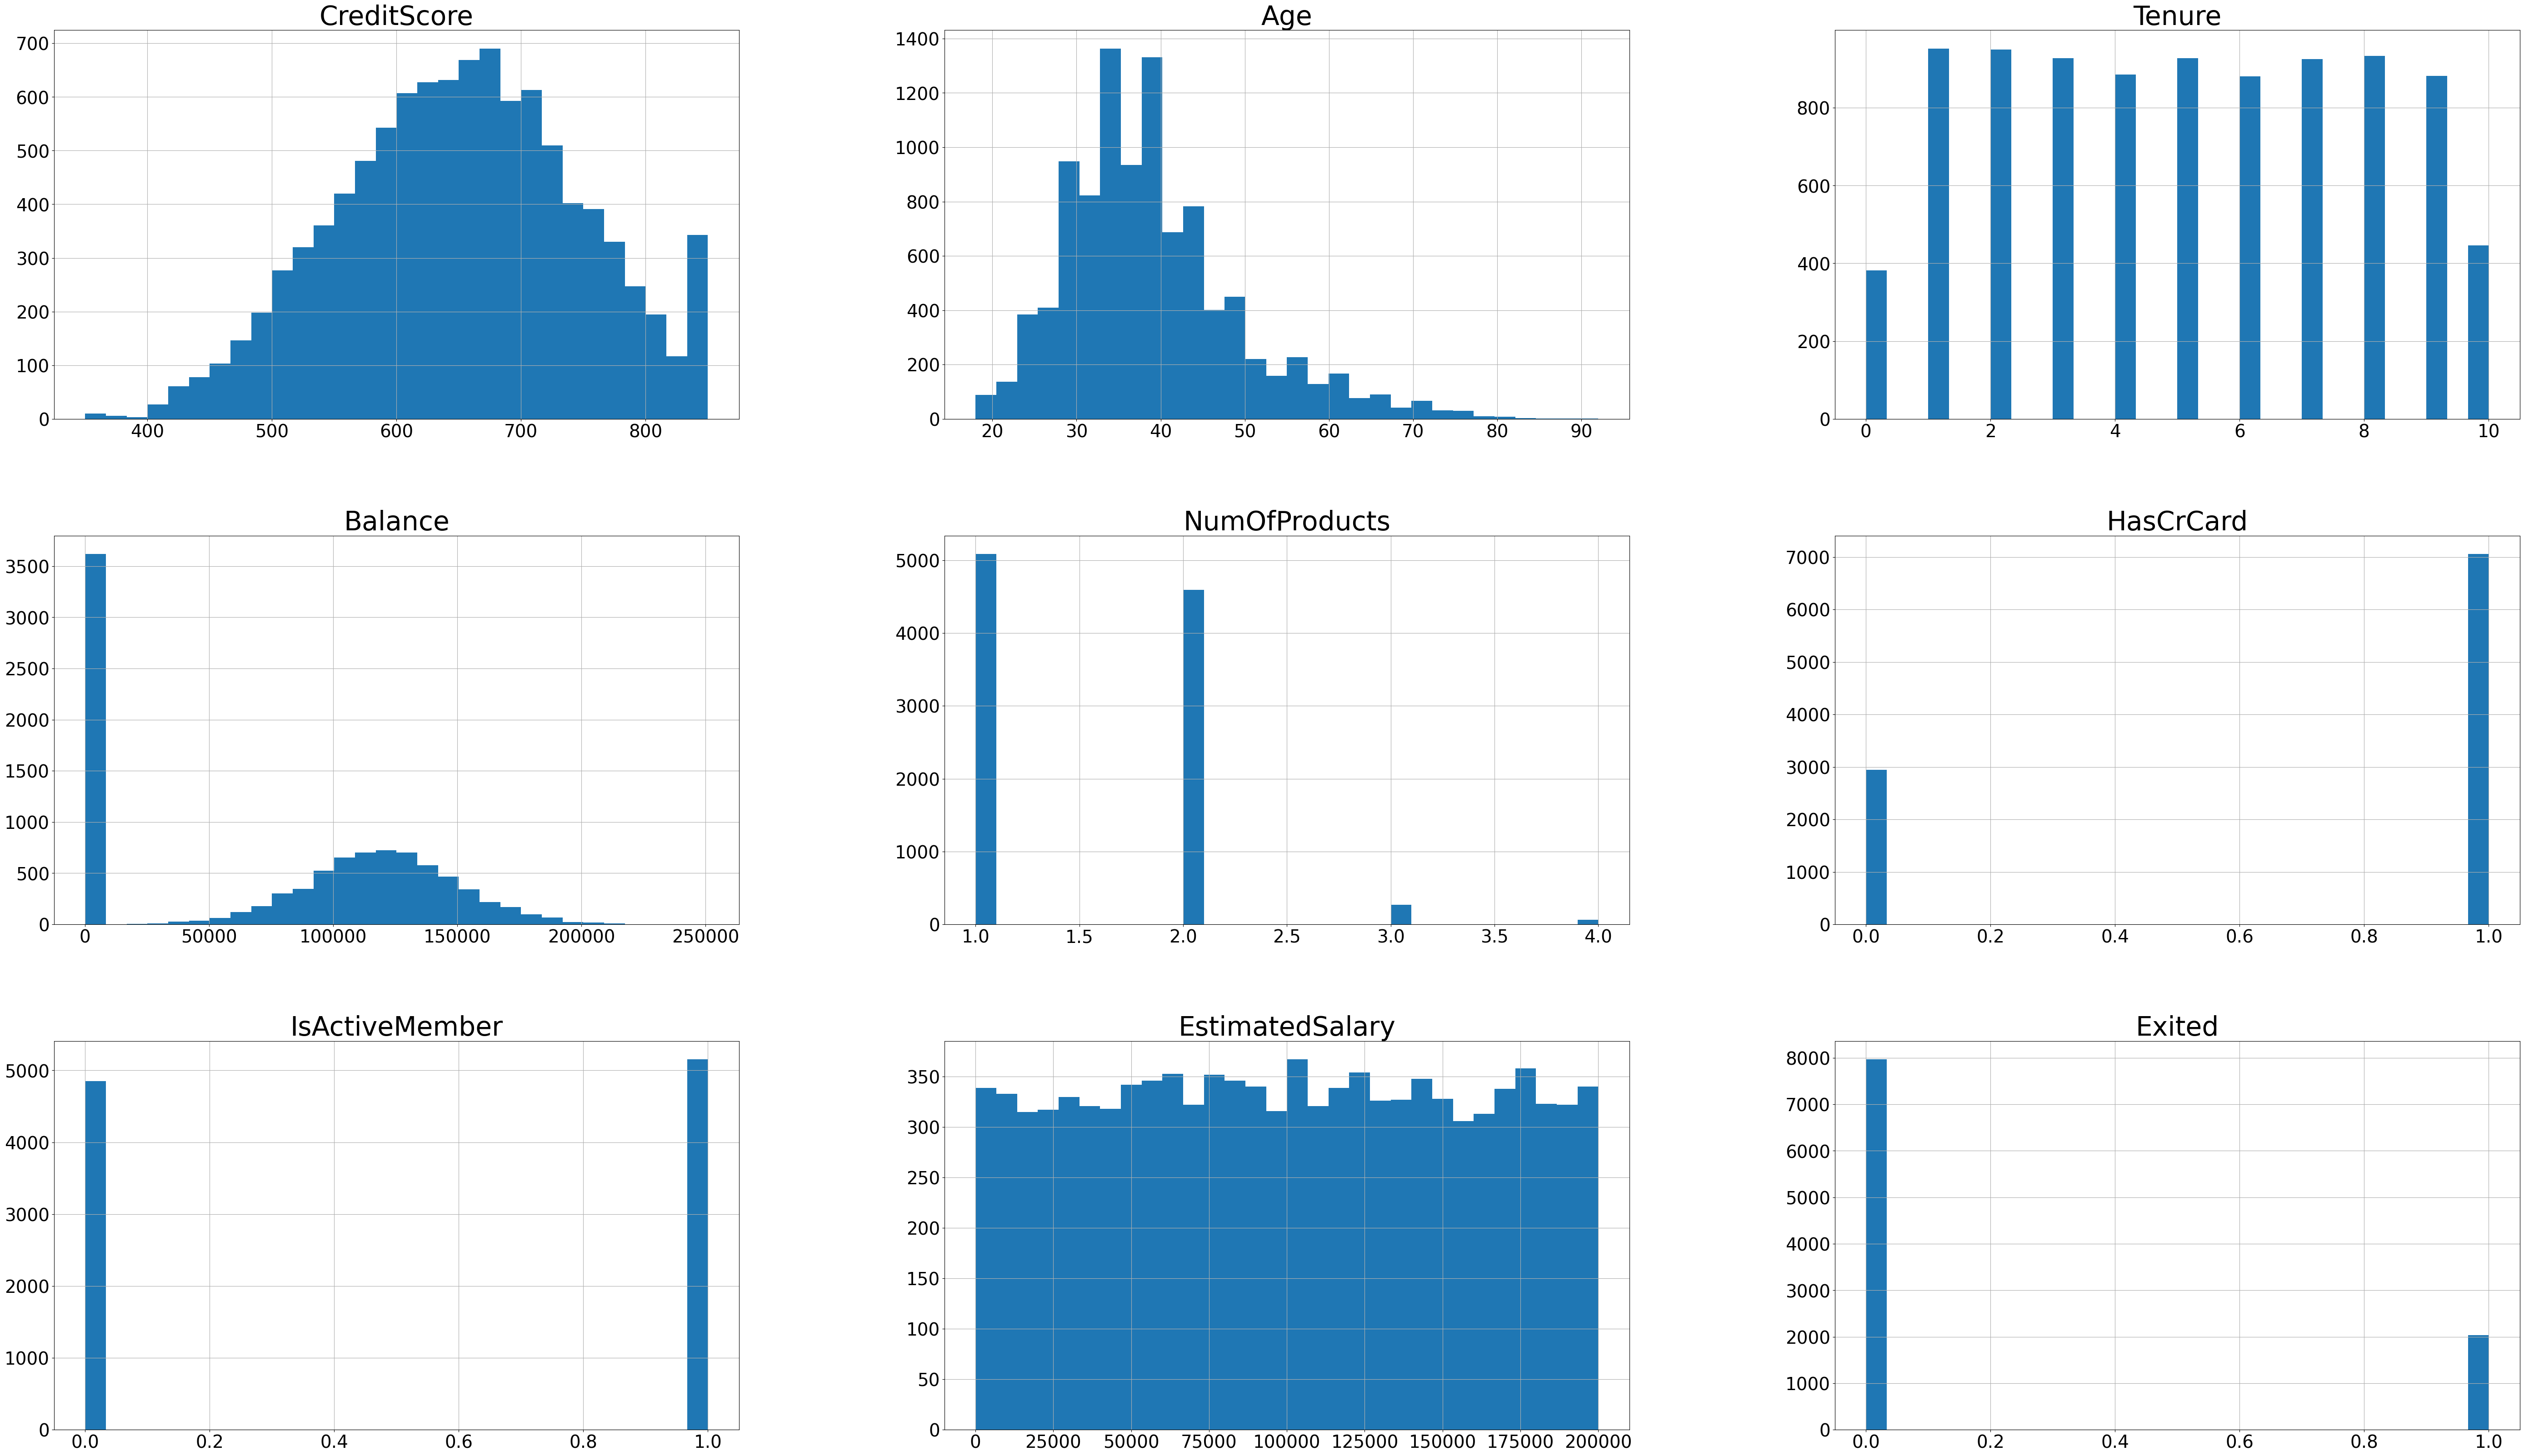

In [5]:
#выведем распределения признаков в датасете
params = {'axes.titlesize':'42',
          'xtick.labelsize':'28',
          'ytick.labelsize':'28'}
plt.rcParams.update(params)
data.drop(columns=['CustomerId', 'RowNumber']).hist(figsize=(70, 40), bins=30);

In [6]:
#видим, что RowNumber дублирует индексы, устраним этот момент
data = data.drop('RowNumber', axis=1)

In [7]:
#список всех признаков
data.columns.str.lower()

Index(['customerid', 'surname', 'creditscore', 'geography', 'gender', 'age',
       'tenure', 'balance', 'numofproducts', 'hascrcard', 'isactivemember',
       'estimatedsalary', 'exited'],
      dtype='object')

In [8]:
#приведем названия признаков к удобному виду
data.columns = ['customer_id', 'surname', 'credit_score', 'geography', 'gender', 'age',
       'tenure', 'balance', 'num_of_products', 'has_cr_card', 'is_active_member',
       'estimated_salary', 'exited']

In [9]:
#посмотрим пропуски
data.isna().mean() * 100

customer_id         0.00
surname             0.00
credit_score        0.00
geography           0.00
gender              0.00
age                 0.00
tenure              9.09
balance             0.00
num_of_products     0.00
has_cr_card         0.00
is_active_member    0.00
estimated_salary    0.00
exited              0.00
dtype: float64

In [10]:
#посмотрим уникальные значения в колонке с пропусками
#встречаются только целочисленные значения
data.tenure.unique()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., nan])

In [11]:
#посмотрим среднее и медианные значения, различий практически нет
#в среднем 5 лет люди являются клиентом банка
data.tenure.mean(), data.tenure.median()

(4.997690023099769, 5.0)

In [12]:
#заполним медианным значением пропуски
data.tenure = data.tenure.fillna(data.tenure.median())

In [13]:
#Рассмотрим всех уникальных пользователей, все уникальны, дубликатов нет
len(data.customer_id.unique())

10000

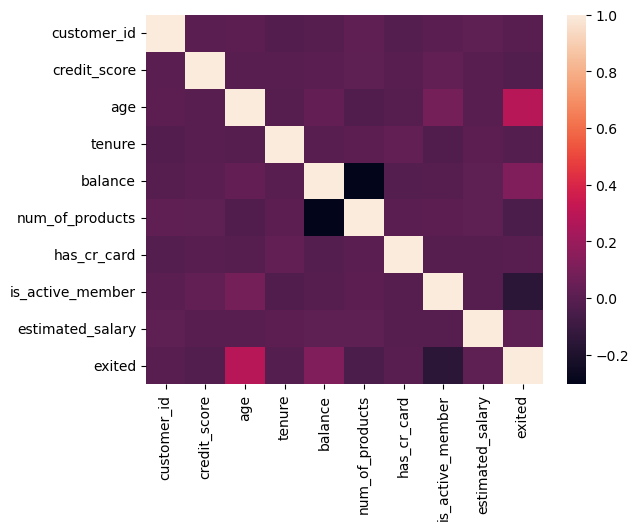

In [14]:
#чтобы учесть коллинеарность посмотрим корреляции признаков
params = {'xtick.labelsize':'10',
          'ytick.labelsize':'10'}
plt.rcParams.update(params)

sns.heatmap(data.corr());

Сильно скоррелированных признаков не обнаружено

In [15]:
#отделим признаки и таргет, имя и ID клиента использовать в обучении моделей не будем
features = data.drop(columns=['customer_id', 'surname', 'exited'])
target = data.exited

In [16]:
#категориальные и числовые признаки
features_cat = ['geography', 'gender']
features_num = features.drop(columns=features_cat).columns

### 1.3 Деление выборки на обучающую, валидационную и тестовую

In [17]:
#отделим 60% тренеровочных данных
features_train, features_other, target_train, target_other =\
train_test_split(features, target, test_size=0.4, random_state=12345, stratify=target)
#отделим по 20% на тест и валидацию
features_valid, features_test, target_valid, target_test =\
train_test_split(features_other, target_other, test_size=0.5, random_state=12345, stratify=target_other)

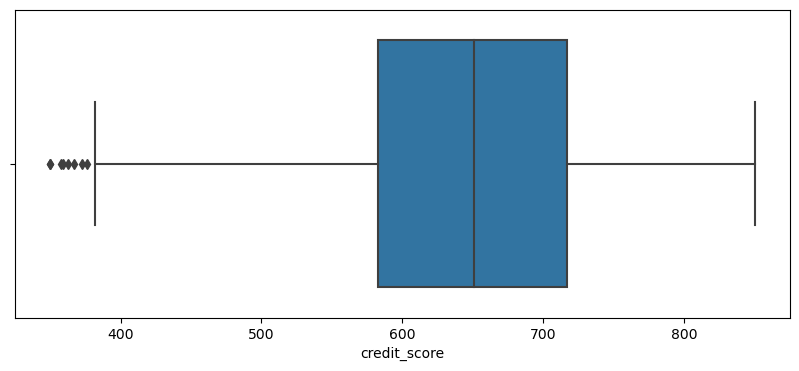

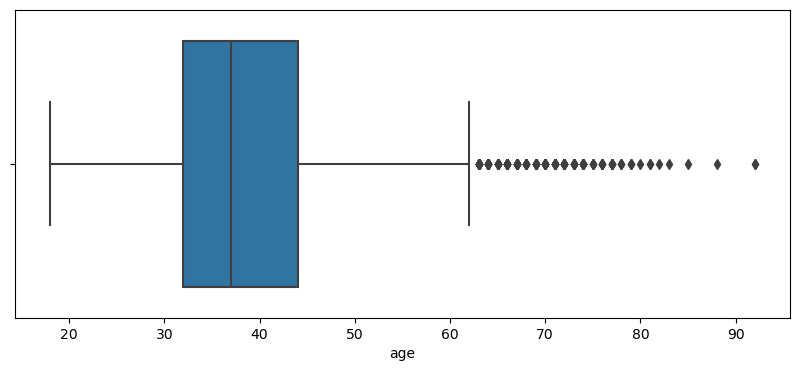

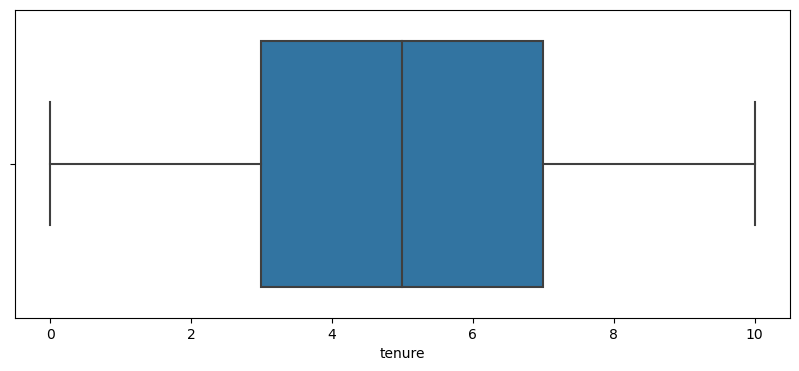

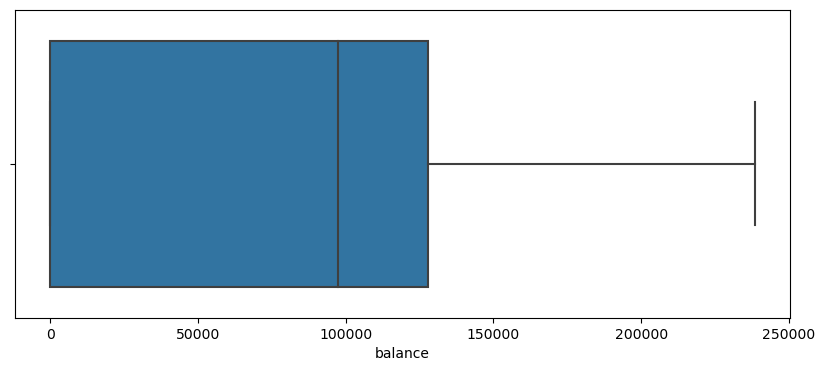

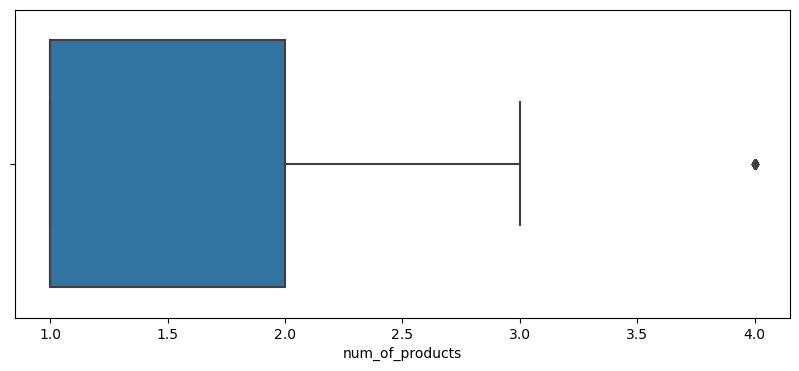

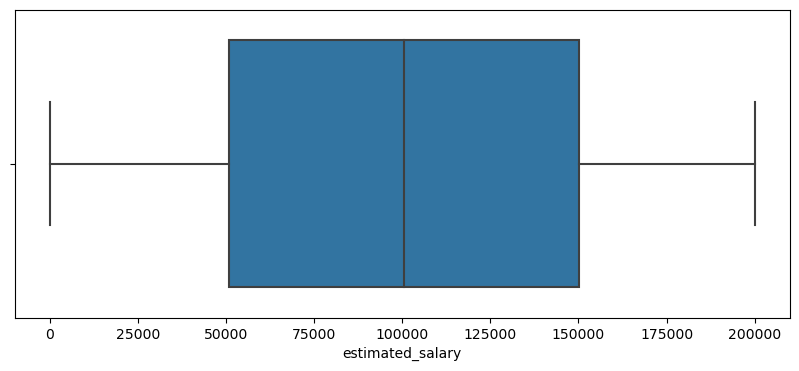

In [18]:
#Посмотрим распределение числовых признаков в обучающей выборке
plt.rcParams["figure.figsize"] = (10,4)
for c in ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']:
    sns.boxplot(x=features_train[features_num][c])
    plt.show()

Есть небольшое количество выбросов в данных. Но, учитывая их небольшое количество, в данной работе обрабатывать их не будем.

### 1.4 Кодирование и масштабирование признаков

In [19]:
#кодирование категориальных признаков методом OHE
encoder = OneHotEncoder(handle_unknown='ignore', drop='first')

features_train_ohe = pd.DataFrame(
    encoder.fit_transform(features_train[features_cat]).toarray(), 
    columns=encoder.get_feature_names_out(), index=features_train.index)
features_valid_ohe = pd.DataFrame(
    encoder.transform(features_valid[features_cat]).toarray(), 
    columns=encoder.get_feature_names_out(), index=features_valid.index)
features_test_ohe = pd.DataFrame(
    encoder.transform(features_test[features_cat]).toarray(), 
    columns=encoder.get_feature_names_out(), index=features_test.index)

In [20]:
#масштабирование признаков
scaler = StandardScaler()

features_train_scaled = pd.DataFrame(
    scaler.fit_transform(features_train[features_num]),
    columns=features_num,
    index=features_train.index)
features_valid_scaled = pd.DataFrame(
    scaler.transform(features_valid[features_num]),
    columns=features_num,
    index=features_valid.index)
features_test_scaled = pd.DataFrame(
    scaler.transform(features_test[features_num]),
    columns=features_num,
    index=features_test.index)

In [21]:
#финальные закодированные признаки
features_train = features_train_ohe.join(features_train_scaled)
features_valid = features_valid_ohe.join(features_valid_scaled)
features_test = features_test_ohe.join(features_test_scaled)

In [22]:
#проверка размерностей закодированных признаков
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(6000, 11)
(2000, 11)
(2000, 11)


**Выводы**:

* Были изучены данные: в данных 10000 строк и 14 колонок.
* В данных присутствуют как категориальные, так и количественные переменные.
* В столбце tenure пропуски заполнены медианой.
* Категориальные переменные были закодированы OHE и стандартизированы с помощью Standard Scaler
* Данные были разделены на обучающую, валидационную и тестовую выборки в соотношении 60:20:20

## 2. ОБУЧЕНИЕ МОДЕЛЕЙ

In [23]:
#оценим несбалансированность классов в целевом признаке
target_train.value_counts(normalize=True)

0    0.796333
1    0.203667
Name: exited, dtype: float64

Данные несбалансированы, ушедших клиентов в 4 раза меньше. 

Сначала проверим модели без учета несбалансированности классов.

### 2.1 Обучение моделей без учета дисбаланса классов

In [24]:
#Случайная модель
dummy_clf = DummyClassifier(strategy='uniform', random_state=12345)
dummy_clf.fit(features_train, target_train)
prediction = dummy_clf.predict(features_valid)

print('accuracy', accuracy_score(target_valid, prediction))
print('precision', precision_score(target_valid, prediction))
print('recall', recall_score(target_valid, prediction))
print('f1', f1_score(target_valid, prediction))

accuracy 0.5025
precision 0.20969337289812068
recall 0.5196078431372549
f1 0.29880197322057794


**Логистическая модель**

In [25]:
#логистическая модель
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
prediction = model.predict(features_valid)

print('accuracy', accuracy_score(target_valid, prediction))
print('precision', precision_score(target_valid, prediction))
print('recall', recall_score(target_valid, prediction))
print('f1', f1_score(target_valid, prediction))

accuracy 0.8105
precision 0.6058394160583942
recall 0.2034313725490196
f1 0.30458715596330277


f1 метрика на уровне базовой модели, предсказание модели практически случайное

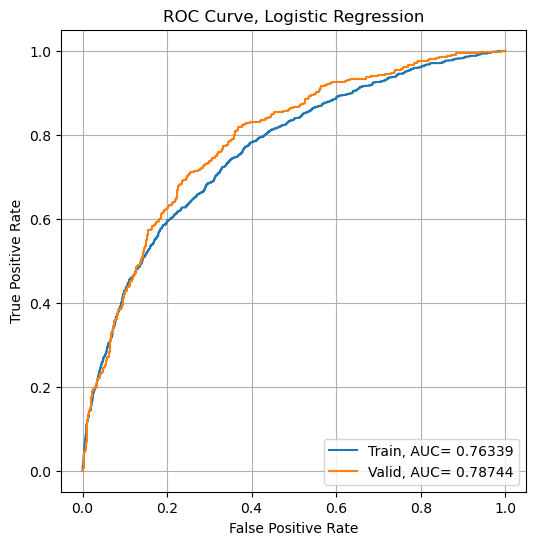

In [26]:
#define metrics
train_pred_proba = model.predict_proba(features_train)[::,1]
valid_pred_proba = model.predict_proba(features_valid)[::,1]
fpr, tpr, _ = roc_curve(target_train, train_pred_proba)
fpr_valid, tpr_valid, _ = roc_curve(target_valid, valid_pred_proba)
auc = round(roc_auc_score(target_train, train_pred_proba), 5)
auc_valid = round(roc_auc_score(target_valid, valid_pred_proba), 5)

#create ROC curve
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
ax.plot (fpr,tpr,label="Train, AUC= "+str(auc))
ax.plot (fpr_valid,tpr_valid,label="Valid, AUC= "+str(auc_valid))
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
ax.set_title('ROC Curve, Logistic Regression', fontsize=12)
ax.legend(loc=4)
plt.grid()
plt.show() 

Модель слабо переобучается, но и слабо распознает отток и на обучающей и на валидационной выборке.

**Random Forest**

Визуализируем влияние разных параметров на значения метрик accuracy и f1

In [27]:
#random_forest c разной глубиной
f1_list = []
depth = []
accuracy = []

for d in tqdm(range(1, 20)):
    model = RandomForestClassifier(max_depth=d, random_state=12345)
    model.fit(features_train, target_train)
    prediction = model.predict(features_valid)
    f1_list.append(f1_score(target_valid, prediction)) 
    accuracy.append(accuracy_score(target_valid, prediction))
    depth.append(d)

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.66it/s]


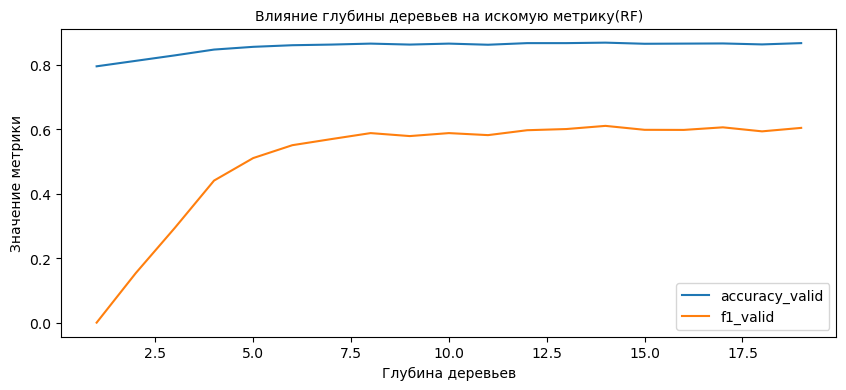

In [28]:
#изменение метрик с увеличением глубины деревьев
pd.DataFrame({'accuracy_valid': accuracy, 'f1_valid': f1_list}, index=depth)\
.plot(figsize=(10, 4)).set(xlabel="Глубина деревьев", ylabel="Значение метрики")     
plt.title('Влияние глубины деревьев на искомую метрику(RF)', fontsize=10);

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:16<00:00,  1.19it/s]


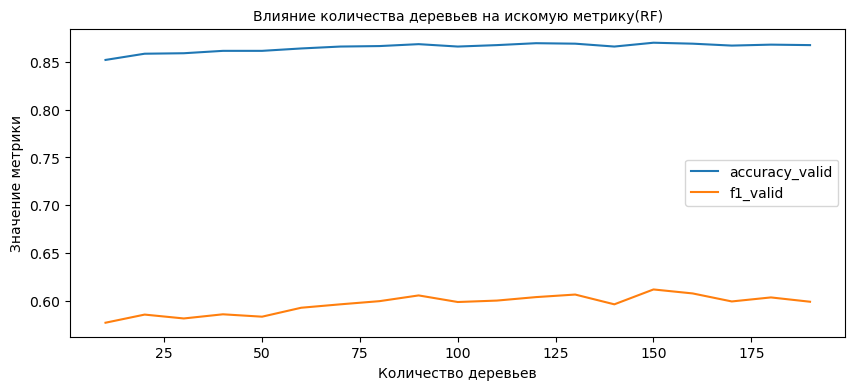

In [29]:
#динамика метрик при разном количестве деревьев при глубине=14
f1_list = []
depth = []
accuracy = []
for n in tqdm((range(10, 200, 10))):
    model = RandomForestClassifier(max_depth=15, n_estimators=n, random_state=12345)
    model.fit(features_train, target_train)
    prediction = model.predict(features_valid)
    f1_list.append(f1_score(target_valid, prediction)) 
    accuracy.append(accuracy_score(target_valid, prediction))
    depth.append(n)
#изменение метрик с увеличением глубины деревьев
pd.DataFrame({'accuracy_valid': accuracy, 'f1_valid': f1_list}, index=depth)\
.plot(figsize=(10, 4)).set(xlabel="Количество деревьев", ylabel="Значение метрики")
plt.title('Влияние количества деревьев на искомую метрику(RF)', fontsize=10);

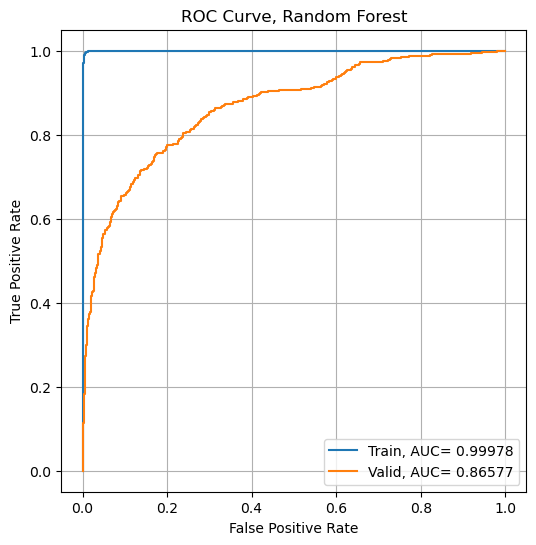

In [30]:
#define metrics
train_pred_proba = model.predict_proba(features_train)[::,1]
valid_pred_proba = model.predict_proba(features_valid)[::,1]
fpr, tpr, _ = roc_curve(target_train, train_pred_proba)
fpr_valid, tpr_valid, _ = roc_curve(target_valid, valid_pred_proba)
auc = round(roc_auc_score(target_train, train_pred_proba), 5)
auc_valid = round(roc_auc_score(target_valid, valid_pred_proba), 5)

#create ROC curve
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
ax.plot (fpr,tpr,label="Train, AUC= "+str(auc))
ax.plot (fpr_valid,tpr_valid,label="Valid, AUC= "+str(auc_valid))
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
ax.set_title('ROC Curve, Random Forest', fontsize=12)
ax.legend(loc=4)
plt.grid()
plt.show() 

Лучшее значение f1 меры 0.611 при количестве деревьев = 150
Видно, что модель достаточно сильно переобучилась на обучающей выборке. Результат на валидации лучше, чем у логистической модели.

## 2.2 Борьба с дисбалансом классов

### 2.2.1 Автоматический параметр балансировки

**Логистическая модель**

для начала попробуем использовать автоматический гиперпараметр class_weight='balanced'

In [31]:
#для логистической модели
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
prediction = model.predict(features_valid)

print('accuracy', accuracy_score(target_valid, prediction))
print('precision', precision_score(target_valid, prediction))
print('recall', recall_score(target_valid, prediction))
print('f1', f1_score(target_valid, prediction))

accuracy 0.7315
precision 0.4117647058823529
recall 0.7377450980392157
f1 0.5285338015803336


Наблюдается прирост 0.2 для f1 меры

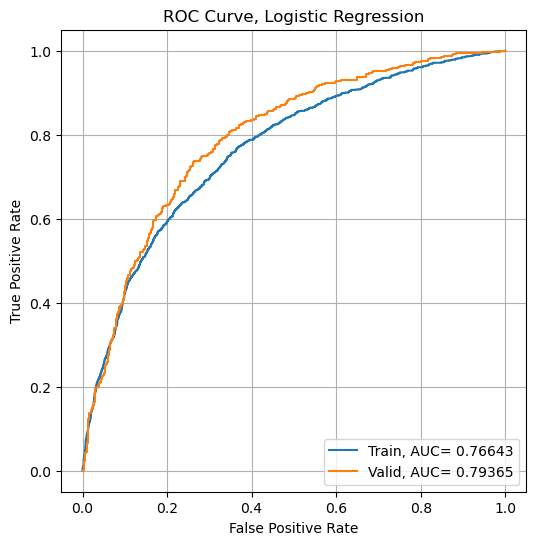

In [32]:
#define metrics
train_pred_proba = model.predict_proba(features_train)[::,1]
valid_pred_proba = model.predict_proba(features_valid)[::,1]
fpr, tpr, _ = roc_curve(target_train, train_pred_proba)
fpr_valid, tpr_valid, _ = roc_curve(target_valid, valid_pred_proba)
auc = round(roc_auc_score(target_train, train_pred_proba), 5)
auc_valid = round(roc_auc_score(target_valid, valid_pred_proba), 5)

#create ROC curve
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
ax.plot (fpr,tpr,label="Train, AUC= "+str(auc))
ax.plot (fpr_valid,tpr_valid,label="Valid, AUC= "+str(auc_valid))
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
ax.set_title('ROC Curve, Logistic Regression', fontsize=12)
ax.legend(loc=4)
plt.grid()
plt.show() 

**Random Forest**

In [33]:
#Попробуем разную глубину деревьев, при n=100
best_f1 = []
best_ac = []
ind = []
probs = []

for d in tqdm(range(1, 20)):
        model = RandomForestClassifier(max_depth=d, random_state=12345, class_weight='balanced')
        model.fit(features_train, target_train)
        prediction = model.predict(features_valid)
        ind.append(d)
        best_ac.append(accuracy_score(target_valid, prediction))
        best_f1.append(f1_score(target_valid, prediction))
        

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:12<00:00,  1.58it/s]


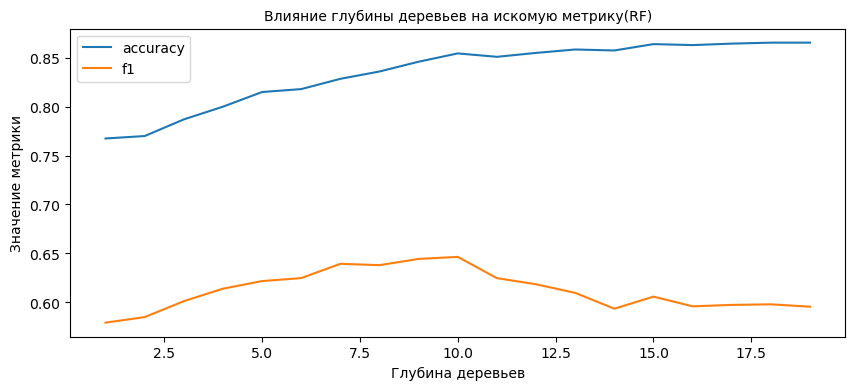

In [34]:
#accuracy, f1 при разной глубине деревьев
pd.DataFrame({'accuracy': best_ac, 'f1': best_f1}, index=ind).plot(figsize=(10, 4))\
.set(xlabel="Глубина деревьев", ylabel="Значение метрики")
plt.title('Влияние глубины деревьев на искомую метрику(RF)', fontsize=10);

После глубины = 10 уже заметное переобучение. 

In [35]:
#теперь попробуем разную глубину деревьев с гиперпараметром class_weight='balanced' в RandomForest
best_f1 = []
best_ac = []
ind = []
probs = []
for n in tqdm((range(10, 200, 10))):
    model = RandomForestClassifier(max_depth=10, n_estimators=n, random_state=12345, class_weight='balanced')
    model.fit(features_train, target_train)
    prediction = model.predict(features_valid)
    ind.append(n)
    best_ac.append(accuracy_score(target_valid, prediction))
    best_f1.append(f1_score(target_valid, prediction))


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:13<00:00,  1.45it/s]


Количество деревьев с лучшей f1-мерой 130


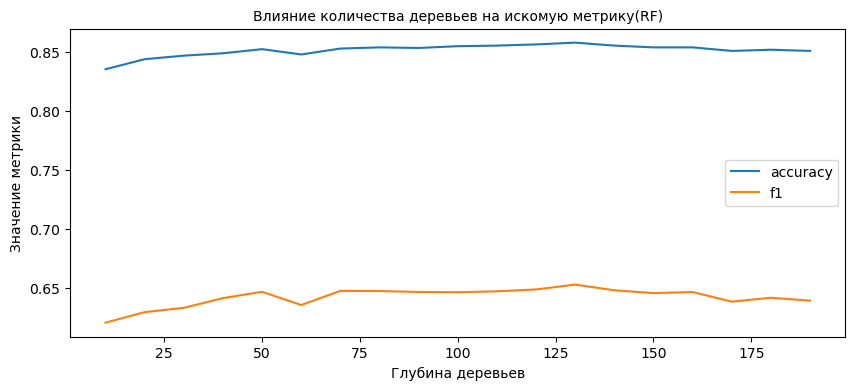

In [36]:
print('Количество деревьев с лучшей f1-мерой', ind[best_f1.index(max(best_f1))])
#accuracy, f1 и aur_roc при разной глубине деревьев
pd.DataFrame({'accuracy': best_ac, 'f1': best_f1}, index=ind).plot(figsize=(10, 4))\
.set(xlabel="Глубина деревьев", ylabel="Значение метрики")
plt.title('Влияние количества деревьев на искомую метрику(RF)', fontsize=10);

In [37]:
#теперь попробуем разное мин. количество образцов на листьях
top_f1 = 0
top_leaf = 0

for leaf in tqdm((range(1, 20))):
    model = RandomForestClassifier(max_depth=10, n_estimators=130, random_state=12345, class_weight='balanced', \
                                   min_samples_leaf=leaf)
    model.fit(features_train, target_train)
    prediction = model.predict(features_valid)
    if f1_score(target_valid, prediction) > top_f1:
        top_f1 = f1_score(target_valid, prediction)
        top_leaf = leaf
print(top_leaf, 'листьев')
print('f1=', top_f1)


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:15<00:00,  1.21it/s]

5 листьев
f1= 0.6528735632183907


5 - оптимальное значение для минимизации переобучения.

Прирост f1 меры около 0.04 относительно небалансированной выборки

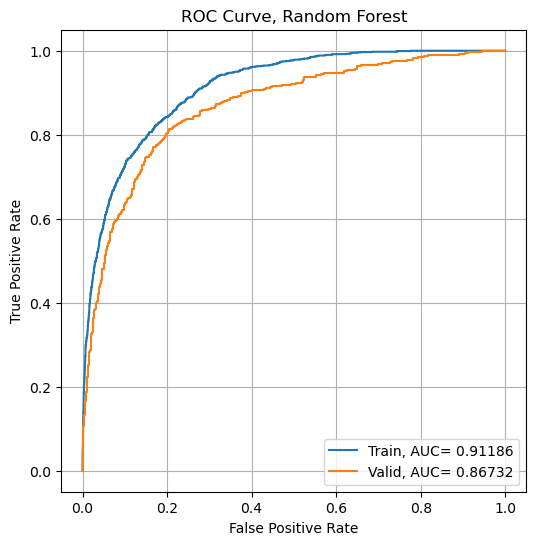

In [38]:
#define metrics
train_pred_proba = model.predict_proba(features_train)[::,1]
valid_pred_proba = model.predict_proba(features_valid)[::,1]
fpr, tpr, _ = roc_curve(target_train, train_pred_proba)
fpr_valid, tpr_valid, _ = roc_curve(target_valid, valid_pred_proba)
auc = round(roc_auc_score(target_train, train_pred_proba), 5)
auc_valid = round(roc_auc_score(target_valid, valid_pred_proba), 5)

#create ROC curve
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
ax.plot (fpr,tpr,label="Train, AUC= "+str(auc))
ax.plot (fpr_valid,tpr_valid,label="Valid, AUC= "+str(auc_valid))
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
ax.set_title('ROC Curve, Random Forest', fontsize=12)
ax.legend(loc=4)
plt.grid()
plt.show() 

Переобучение заметно в гораздо меньшей степени, чем без балансировки классов.

### 2.2.2 Upsampling

Попробуем изменить баланс классов вручную, напишем функцию для ресемплинга

In [39]:
#функция upsempling
def upsampling(features, target, repeat):
    features_zero = features[target == 0]
    features_ones = features[target == 1]
    target_zero = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zero] + repeat * [features_ones])
    target_upsampled = pd.concat([target_zero] + repeat * [target_ones])
        
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [40]:
#попробуем разные значения фракционирования многочисленного признака для RandomForest
#сначала при разной глубине

for multiple in tqdm(range(2, 6)):
    features_upsampled, target_upsampled = upsampling(features_train, target_train, multiple)
    model = RandomForestClassifier(max_depth=10, n_estimators=130, random_state=12345,\
                                      min_samples_leaf=5)
    model.fit(features_upsampled, target_upsampled)
    prediction = model.predict(features_valid)
    
    print('multiple', multiple)
    print('f1_score', f1_score(target_valid, prediction))

 25%|█████████████████████                                                               | 1/4 [00:00<00:02,  1.01it/s]

multiple 2
f1_score 0.6422018348623852


 50%|██████████████████████████████████████████                                          | 2/4 [00:02<00:02,  1.06s/it]

multiple 3
f1_score 0.6338028169014084


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:03<00:01,  1.12s/it]

multiple 4
f1_score 0.6379310344827587


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.14s/it]

multiple 5
f1_score 0.6416243654822334


Лучшее значение метрики = 0.6422 у RF c предыдущими гиперпараметрами при multiple 2, несколько хуже чем у RF с class_weight='balanced' (0.652).

In [41]:
features_upsampled, target_upsampled = upsampling(features_train, target_train, 2)

In [42]:
#Случайная модель
dummy_clf = DummyClassifier(strategy='uniform', random_state=12345)
dummy_clf.fit(features_upsampled, target_upsampled)
prediction = dummy_clf.predict(features_valid)

print('accuracy', accuracy_score(target_valid, prediction))
print('precision', precision_score(target_valid, prediction))
print('recall', recall_score(target_valid, prediction))
print('f1', f1_score(target_valid, prediction))

accuracy 0.5025
precision 0.20969337289812068
recall 0.5196078431372549
f1 0.29880197322057794


**Логистическая модель**

In [43]:
#для логистической модели
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_upsampled, target_upsampled)
prediction = model.predict(features_valid)

print('accuracy', accuracy_score(target_valid, prediction))
print('precision', precision_score(target_valid, prediction))
print('recall', recall_score(target_valid, prediction))
print('f1', f1_score(target_valid, prediction))

accuracy 0.7315
precision 0.4117647058823529
recall 0.7377450980392157
f1 0.5285338015803336


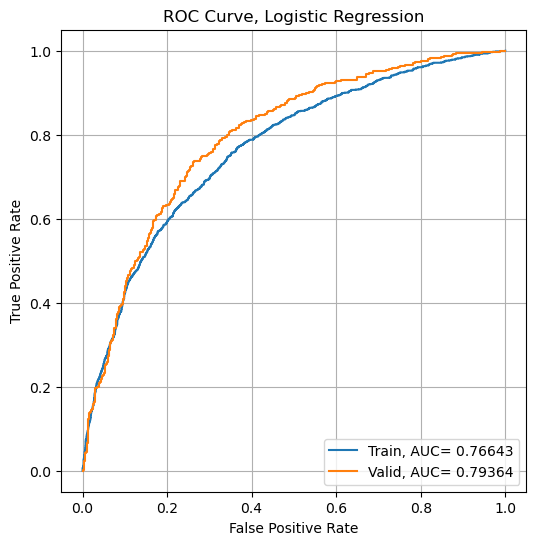

In [44]:
#define metrics
train_pred_proba = model.predict_proba(features_train)[::,1]
valid_pred_proba = model.predict_proba(features_valid)[::,1]
fpr, tpr, _ = roc_curve(target_train, train_pred_proba)
fpr_valid, tpr_valid, _ = roc_curve(target_valid, valid_pred_proba)
auc = round(roc_auc_score(target_train, train_pred_proba), 5)
auc_valid = round(roc_auc_score(target_valid, valid_pred_proba), 5)

#create ROC curve
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
ax.plot (fpr,tpr,label="Train, AUC= "+str(auc))
ax.plot (fpr_valid,tpr_valid,label="Valid, AUC= "+str(auc_valid))
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
ax.set_title('ROC Curve, Logistic Regression', fontsize=12)
ax.legend(loc=4)
plt.grid()
plt.show() 

**Random Forest**

In [45]:
#Попробуем разные глубины деревьев, при n=100
best_f1 = []
best_ac = []
ind = []

for d in tqdm(range(1, 20)):
        model = RandomForestClassifier(max_depth=d, random_state=12345)
        model.fit(features_upsampled, target_upsampled)
        prediction = model.predict(features_valid)
        ind.append(d)
        best_ac.append(accuracy_score(target_valid, prediction))
        best_f1.append(f1_score(target_valid, prediction))

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:13<00:00,  1.38it/s]


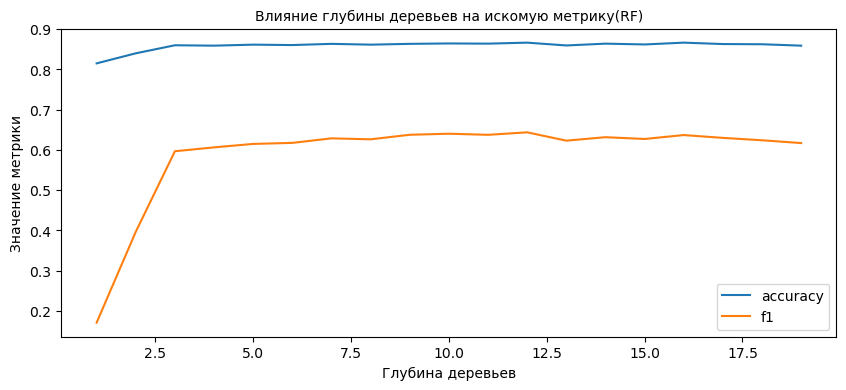

In [46]:
pd.DataFrame({'accuracy': best_ac, 'f1': best_f1}, index=ind).plot(figsize=(10, 4))\
.set(xlabel="Глубина деревьев", ylabel="Значение метрики")
plt.title('Влияние глубины деревьев на искомую метрику(RF)', fontsize=10);

In [47]:
#Разное количество деревьев при глубине 12

best_f1, best_n = [], []
best_ac = []
for n in tqdm((range(10, 250, 10))):
    model = RandomForestClassifier(max_depth=12, n_estimators=n, random_state=12345, class_weight='balanced')
    model.fit(features_upsampled, target_upsampled)
    prediction = model.predict(features_valid)
    best_f1.append(f1_score(target_valid, prediction))
    best_ac.append(accuracy_score(target_valid, prediction))
    best_n.append(n)

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:26<00:00,  1.11s/it]


80 деревьев 0.6432038834951457


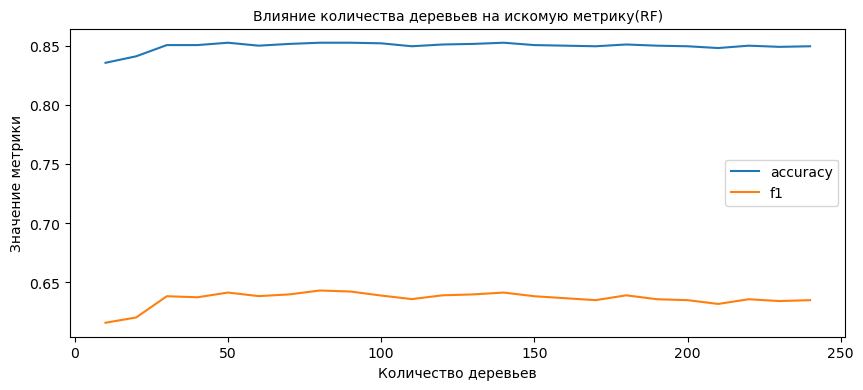

In [48]:
print(best_n[best_f1.index(max(best_f1))], 'деревьев', max(best_f1))
pd.DataFrame({'accuracy': best_ac, 'f1': best_f1}, index=best_n).plot(figsize=(10, 4))\
.set(xlabel="Количество деревьев", ylabel="Значение метрики")
plt.title('Влияние количества деревьев на искомую метрику(RF)', fontsize=10);

In [49]:
#мин. количество образцов на листьях
top_f1 = 0
top_leaf = 0
for leaf in tqdm((range(1, 20))):
    model = RandomForestClassifier(max_depth=12, n_estimators=80, random_state=12345, min_samples_leaf=leaf)
    model.fit(features_upsampled, target_upsampled)
    prediction = model.predict(features_valid)
    if f1_score(target_valid, prediction) > top_f1:
        top_f1 = f1_score(target_valid, prediction)
        top_leaf = leaf
print(top_leaf)
print(top_f1)

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.59it/s]

1
0.6506666666666666


Также наблюдается прирост искомой метрики относительно несбалансированной выборки

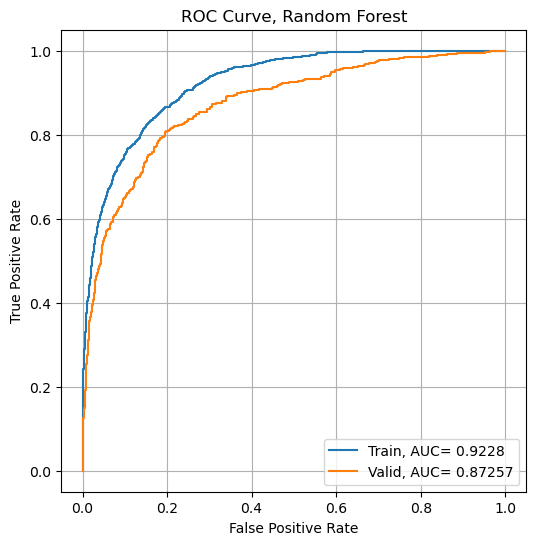

In [50]:
#define metrics
train_pred_proba = model.predict_proba(features_train)[::,1]
valid_pred_proba = model.predict_proba(features_valid)[::,1]
fpr, tpr, _ = roc_curve(target_train, train_pred_proba)
fpr_valid, tpr_valid, _ = roc_curve(target_valid, valid_pred_proba)
auc = round(roc_auc_score(target_train, train_pred_proba), 5)
auc_valid = round(roc_auc_score(target_valid, valid_pred_proba), 5)

#create ROC curve
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
ax.plot (fpr,tpr,label="Train, AUC= "+str(auc))
ax.plot (fpr_valid,tpr_valid,label="Valid, AUC= "+str(auc_valid))
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
ax.set_title('ROC Curve, Random Forest', fontsize=12)
ax.legend(loc=4)
plt.grid()
plt.show() 

Модель переобучена в большей степени, чем при автоматической балансировке классов, но детекция положительных классов несколько выше.

### 2.2.3 SMOTE

In [51]:
sm = SMOTE(random_state=12345)
features_train_sm, target_train_sm = sm.fit_resample(features_train, target_train)

**Логистическая модель**

In [52]:
#для логистической модели
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_train_sm, target_train_sm)
prediction = model.predict(features_valid)

print('accuracy', accuracy_score(target_valid, prediction))
print('precision', precision_score(target_valid, prediction))
print('recall', recall_score(target_valid, prediction))
print('f1', f1_score(target_valid, prediction))

accuracy 0.7365
precision 0.41770401106500693
recall 0.7401960784313726
f1 0.5340406719717065


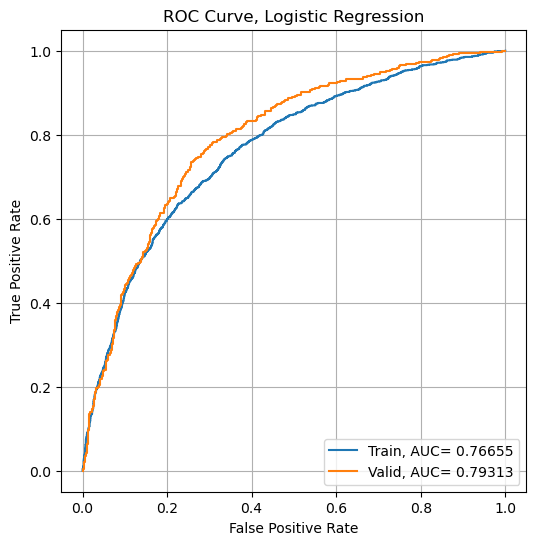

In [53]:
#define metrics
train_pred_proba = model.predict_proba(features_train)[::,1]
valid_pred_proba = model.predict_proba(features_valid)[::,1]
fpr, tpr, _ = roc_curve(target_train, train_pred_proba)
fpr_valid, tpr_valid, _ = roc_curve(target_valid, valid_pred_proba)
auc = round(roc_auc_score(target_train, train_pred_proba), 5)
auc_valid = round(roc_auc_score(target_valid, valid_pred_proba), 5)

#create ROC curve
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
ax.plot (fpr,tpr,label="Train, AUC= "+str(auc))
ax.plot (fpr_valid,tpr_valid,label="Valid, AUC= "+str(auc_valid))
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
ax.set_title('ROC Curve, Logistic Regression', fontsize=12)
ax.legend(loc=4)
plt.grid()
plt.show() 

**Random Forest**

In [54]:
#Попробуем разные глубины деревьев, при n=100
best_f1 = []
best_ac = []
ind = []

for d in tqdm(range(1, 20)):
        model = RandomForestClassifier(max_depth=d, random_state=12345)
        model.fit(features_train_sm, target_train_sm)
        prediction = model.predict(features_valid)
        ind.append(d)
        best_ac.append(accuracy_score(target_valid, prediction))
        best_f1.append(f1_score(target_valid, prediction))

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:20<00:00,  1.06s/it]


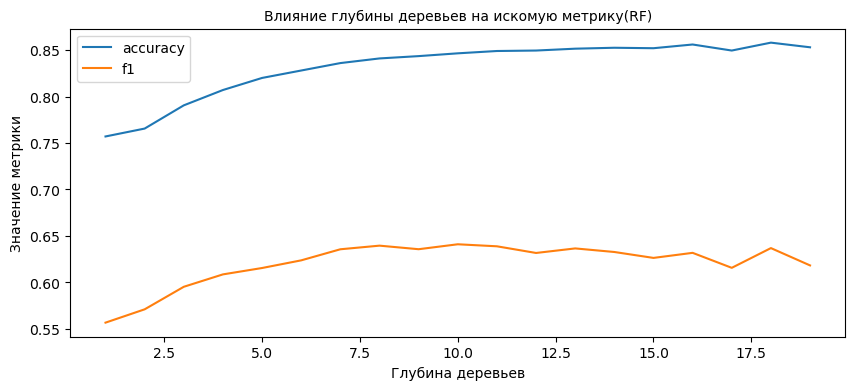

In [55]:
pd.DataFrame({'accuracy': best_ac, 'f1': best_f1}, index=ind).plot(figsize=(10, 4))\
.set(xlabel="Глубина деревьев", ylabel="Значение метрики")
plt.title('Влияние глубины деревьев на искомую метрику(RF)', fontsize=10);

In [56]:
#Разное количество деревьев

best_f1, best_n = [], []
best_ac = []
for n in tqdm((range(10, 250, 10))):
    model = RandomForestClassifier(max_depth=10, n_estimators=n, random_state=12345, class_weight='balanced')
    model.fit(features_train_sm, target_train_sm)
    prediction = model.predict(features_valid)
    best_f1.append(f1_score(target_valid, prediction))
    best_n.append(n)
    best_ac.append(accuracy_score(target_valid, prediction))

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:34<00:00,  1.45s/it]


90 деревьев 0.6456876456876457


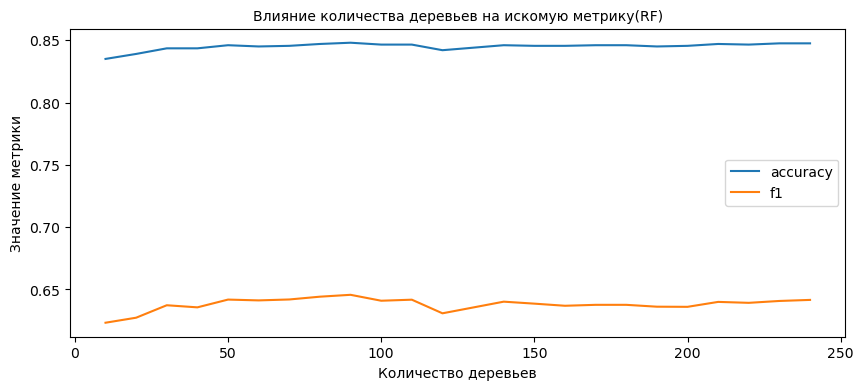

In [57]:
print(best_n[best_f1.index(max(best_f1))], 'деревьев', max(best_f1))
pd.DataFrame({'accuracy': best_ac, 'f1': best_f1}, index=best_n).plot(figsize=(10, 4))\
.set(xlabel="Количество деревьев", ylabel="Значение метрики")
plt.title('Влияние количества деревьев на искомую метрику(RF)', fontsize=10);

In [58]:
#мин. количество образцов на листьях
top_f1 = 0
top_leaf = 0
for leaf in tqdm((range(1, 20))):
    model = RandomForestClassifier(max_depth=10, n_estimators=90, random_state=12345, min_samples_leaf=leaf)
    model.fit(features_train_sm, target_train_sm)
    prediction = model.predict(features_valid)
    if f1_score(target_valid, prediction) > top_f1:
        top_f1 = f1_score(target_valid, prediction)
        top_leaf = leaf
print(top_leaf)
print(top_f1)

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:18<00:00,  1.01it/s]

2
0.6518171160609614


Значение метрик соизмеримо с сlass_weight='balanced'.

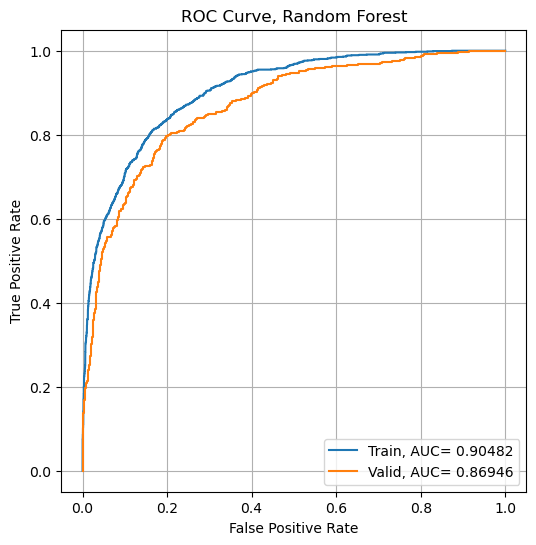

In [59]:
#define metrics
train_pred_proba = model.predict_proba(features_train)[::,1]
valid_pred_proba = model.predict_proba(features_valid)[::,1]
fpr, tpr, _ = roc_curve(target_train, train_pred_proba)
fpr_valid, tpr_valid, _ = roc_curve(target_valid, valid_pred_proba)
auc = round(roc_auc_score(target_train, train_pred_proba), 5)
auc_valid = round(roc_auc_score(target_valid, valid_pred_proba), 5)

#create ROC curve
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
ax.plot (fpr,tpr,label="Train, AUC= "+str(auc))
ax.plot (fpr_valid,tpr_valid,label="Valid, AUC= "+str(auc_valid))
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
ax.set_title('ROC Curve, Random Forest', fontsize=12)
ax.legend(loc=4)
plt.grid()
plt.show() 

**Catboost**

Также можно привести пример автоматической балансировки весов встроенную в модель градиентного бустинга catboost

In [60]:
cat = CatBoostClassifier(random_state=12345, n_estimators=2000, depth=5, auto_class_weights='Balanced', verbose=0)
cat.fit(features_train, target_train)
print('f1_score с автоматической балансировкой классов', f1_score(target_valid, cat.predict(features_valid)))

f1_score с автоматической балансировкой классов 0.6437499999999999


In [61]:
cat = CatBoostClassifier(random_state=12345, n_estimators=2000, depth=5, verbose=0)
cat.fit(features_train, target_train)
print('f1_score без балансировкой классов', f1_score(target_valid, cat.predict(features_valid)))

f1_score без балансировкой классов 0.6156069364161851


Стоит отметить, что даже без балансировки классов модель градиентного бустинга показала неплохой результат.

**Выводы**:
1. При использовании алгоритмов ML, чувствительные к балансу классы алгоритма переобучаются. Необходимо производить балансировку перед обучением моделей.
2. Были опробованы три метода борьбы с дисбалансом (Ручной resempling, smote и автоматический параметр сlass_weight='balanced'). Все методы  показали положительные результаты.
3. С помощью модели случайного леса удалось достичь искомой метрики f1 = 0.59.

## 3 Тестирование модели

In [62]:
#для повышения качества обьединим обучающие и валидационные выборки
features_train, target_train = pd.concat([features_train, features_valid]), pd.concat([target_train, target_valid])

In [63]:
#тестирование модели
model = RandomForestClassifier(max_depth=10, n_estimators=130, min_samples_leaf=5, random_state=12345, class_weight='balanced')
model.fit(features_train, target_train)
prediction = model.predict(features_test)

print('accuracy', accuracy_score(target_test, prediction))
print('precision', precision_score(target_test, prediction))
print('recall', recall_score(target_test, prediction))
print('f1', f1_score(target_test, prediction))
print('roc_auc', roc_auc_score(target_test, model.predict_proba(features_test)[:, 1]))

accuracy 0.832
precision 0.5744234800838575
recall 0.6732186732186732
f1 0.6199095022624436
roc_auc 0.8609302677099288


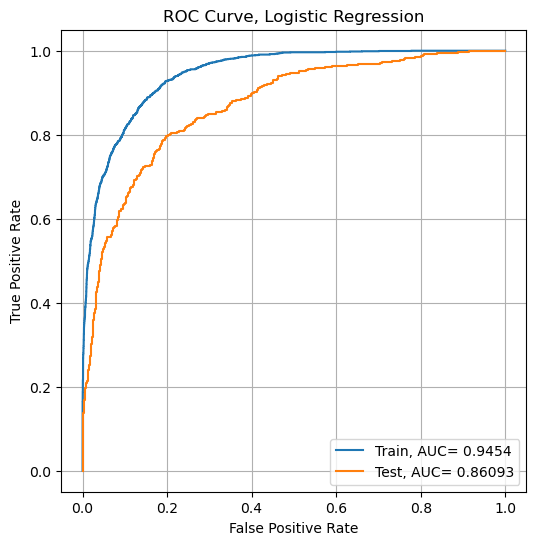

In [64]:
#define metrics
train_pred_proba = model.predict_proba(features_train)[::,1]
test_pred_proba = model.predict_proba(features_test)[::,1]
fpr, tpr, _ = roc_curve(target_train, train_pred_proba)
fpr_test, tpr_test, _ = roc_curve(target_test, test_pred_proba)
auc = round(roc_auc_score(target_train, train_pred_proba), 5)
auc_test = round(roc_auc_score(target_test, test_pred_proba), 5)

#create ROC curve
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
ax.plot (fpr,tpr,label="Train, AUC= "+str(auc))
ax.plot (fpr_valid,tpr_valid,label="Test, AUC= "+str(auc_test))
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
ax.set_title('ROC Curve, Logistic Regression', fontsize=12)
ax.legend(loc=4)
plt.grid()
plt.show() 

## Выводы:

1. Данные были изучены и обработаны. Для обучения моделей данные были разделены на обучающую, валидационную и тестовые в соотношении 3:1:1.
2. Был исследован дисбаланс классов.
3. Были построены модели без учета дисбаланса классов и узучены несколько видов борьбы с дисбалансом: upsempling, smote и автоматический гиперпараметр class_weight: методы показали близкие значения метрик. 
4. Лучшее значение метрики удалось достигнуть с помощью RandomForestClassifier с гиперпараметром :max_depth=10, n_estimators=130, min_samples_leaf=5, random_state=12345, class_weight='balanced'.
7. Удалось повысить значение f1 меры выше необходимого порога 0.59